In [6]:
%pip install spyndex -q
#%pip install odc-stac -q
#%pip install stackstac -q

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from rasterio.windows import from_bounds
from rasterio import plot
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pystac_client

import spyndex
import stackstac


In [8]:
def initialize_stac_client(stac_url):
    """
    Initialize and return a STAC client for a given STAC API URL.
    Parameters:
    - stac_url (str): The URL of the STAC API.
    Returns:
    - A pystac_client.Client object
    """
    client = pystac_client.Client.open(stac_url)
    return client


def query_stac_api_return_collection(client, collections, bbox, start_date=None, end_date=None, max_items=10):
    """
    Query a STAC API for items within a bounding box and date range for specific collections.
    Parameters:
    - client: The STAC client initialized with `initialize_stac_client`.
    - bbox (list): The bounding box for the query [min_lon, min_lat, max_lon, max_lat].
    - collections (list): A list of collection IDs to include in the query.
    - start_date (str, optional): The start date for the query (YYYY-MM-DD). Defaults to None.
    - end_date (str, optional): The end date for the query (YYYY-MM-DD). Defaults to None.
    - limit (int): Maximum number of items to return.    
    Returns:
    - A list of STAC Items that match the query parameters.
    """

    search_params = {
        "bbox": bbox,
        "collections": [collections],
        "max_items": max_items
    }
    if start_date and end_date:
        search_params["datetime"] = f"{start_date}/{end_date}"

    search = client.search(**search_params).item_collection()

    return search



In [9]:
geom_fpath = '/workspaces/data-notebooks/notebooks/sandbox/data/input-data/dissolved-boundaries.geojson'
geom = gpd.read_file(geom_fpath)

bbox = list(geom.total_bounds)
lat = geom.centroid.x[0]
long = geom.centroid.y[0]

stac_url_sentinel = "https://earth-search.aws.element84.com/v1"
collection_sentinel = "sentinel-2-l2a"

start_date = "2023-01-01"
end_date = "2023-04-01"

client_sentinel = initialize_stac_client(stac_url_sentinel)


/tmp/ipykernel_49929/74160282.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = geom.centroid.x[0]
/tmp/ipykernel_49929/74160282.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  long = geom.centroid.y[0]


In [10]:
items_sentinel = query_stac_api_return_collection(client_sentinel, collection_sentinel, bbox, start_date, end_date)

In [11]:
# from the above collection of STAC items, only get the red and nir bands, resample to 30m, and only get pixels that fall within the bbox provided.
stack = stackstac.stack(items_sentinel,
                        resolution = 50,
                        assets = ['blue','green','red', 'rededge1', 'nir', 'swir16'],
                        bounds_latlon=bbox)
stack

/opt/conda/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-4bc8013452ea503d9e15b6d85ef51459' (time: 10,
                                                                band: 6,
                                                                y: 196, x: 250)> Size: 24MB
dask.array<fetch_raster_window, shape=(10, 6, 196, 250), dtype=float64, chunksize=(1, 1, 196, 250), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 80B 2023-0...
    id                                       (time) <U24 960B 'S2B_50JMN_2023...
  * band                                     (band) <U8 192B 'blue' ... 'swir16'
  * x                                        (x) float64 2kB 4.28e+05 ... 4.4...
  * y                                        (y) float64 2kB 6.768e+06 ... 6....
    s2:vegetation_percentage                 (time) float64 80B 0.02278 ... 0...
    ...                                       ...
    gsd                                      (band) int64 48B 10 10 10 20 10 20
    raster:bands                             (band) object 48B {'nodata': 0, ...
    common_name                              (band) <U7 168B 'blue' ... 'swir16'
    center_wavelength                        (band) float64 48B 0.49 ... 1.61
    full_width_half_max                      (band) float64 48B 0.098 ... 0.143
    epsg                                     int64 8B 32750
Attributes:
    spec:        RasterSpec(epsg=32750, bounds=(428050, 6757700, 440550, 6767...
    crs:         epsg:32750
    transform:   | 50.00, 0.00, 428050.00|\n| 0.00,-50.00, 6767500.00|\n| 0.0...
    resolution:  50

Use the Spyndex package to map satellite bands to parameters, and then calculate whatever indices we want. 

In [12]:
lowcloud = stack[stack["eo:cloud_cover"] < 10]
monthly = lowcloud.resample(time="MS").median("time", keep_attrs=True)
rgb = monthly.sel(band=["red", "green", "blue"])
rgb

<xarray.DataArray 'stackstac-4bc8013452ea503d9e15b6d85ef51459' (time: 2,
                                                                band: 3,
                                                                y: 196, x: 250)> Size: 2MB
dask.array<getitem, shape=(2, 3, 196, 250), dtype=float64, chunksize=(1, 3, 196, 250), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * band                                     (band) <U8 96B 'red' 'green' 'blue'
  * x                                        (x) float64 2kB 4.28e+05 ... 4.4...
  * y                                        (y) float64 2kB 6.768e+06 ... 6....
    s2:saturated_defective_pixel_percentage  int64 8B 0
    s2:snow_ice_percentage                   int64 8B 0
    proj:epsg                                int64 8B 32750
    ...                                       ...
    raster:bands                             (band) object 24B {'nodata': 0, ...
    common_name                              (band) <U7 84B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32750
  * time                                     (time) datetime64[ns] 16B 2023-0...
Attributes:
    spec:        RasterSpec(epsg=32750, bounds=(428050, 6757700, 440550, 6767...
    crs:         epsg:32750
    transform:   | 50.00, 0.00, 428050.00|\n| 0.00,-50.00, 6767500.00|\n| 0.0...
    resolution:  50

In [13]:
data = rgb.compute()

In [14]:
# using the data array set up using stackstac, we can now comput a bunch of indices:
monthly['NDVI'] = spyndex.indices.NDVI.compute(
        N = monthly.sel(band="nir"),
        R = monthly.sel(band="red"),
).clip(-1,1)

monthly['NDMI'] = spyndex.indices.NDMI.compute(
        N = monthly.sel(band="nir"),
        S1 = monthly.sel(band="swir16")
)

monthly['NDWI'] = spyndex.indices.NDWI.compute(
        G = monthly.sel(band="green"),
        N = monthly.sel(band="nir")
)

monthly['NDREI'] = spyndex.indices.NDREI.compute(
        N = monthly.sel(band="nir"),
        RE1 = monthly.sel(band="rededge1")
)

monthly['CIRE'] = spyndex.indices.CIRE.compute(
        N = monthly.sel(band="nir"),
        RE1 = monthly.sel(band="rededge1")
)
monthly

<xarray.DataArray 'stackstac-4bc8013452ea503d9e15b6d85ef51459' (time: 2,
                                                                band: 6,
                                                                y: 196, x: 250)> Size: 5MB
dask.array<stack, shape=(2, 6, 196, 250), dtype=float64, chunksize=(1, 6, 196, 250), chunktype=numpy.ndarray>
Coordinates: (12/32)
  * band                                     (band) <U8 192B 'blue' ... 'swir16'
  * x                                        (x) float64 2kB 4.28e+05 ... 4.4...
  * y                                        (y) float64 2kB 6.768e+06 ... 6....
    s2:saturated_defective_pixel_percentage  int64 8B 0
    s2:snow_ice_percentage                   int64 8B 0
    proj:epsg                                int64 8B 32750
    ...                                       ...
  * time                                     (time) datetime64[ns] 16B 2023-0...
    NDVI                                     (time, y, x) float64 784kB dask.array<chunksize=(1, 196, 250), meta=np.ndarray>
    NDMI                                     (time, y, x) float64 784kB dask.array<chunksize=(1, 196, 250), meta=np.ndarray>
    NDWI                                     (time, y, x) float64 784kB dask.array<chunksize=(1, 196, 250), meta=np.ndarray>
    NDREI                                    (time, y, x) float64 784kB dask.array<chunksize=(1, 196, 250), meta=np.ndarray>
    CIRE                                     (time, y, x) float64 784kB dask.array<chunksize=(1, 196, 250), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32750, bounds=(428050, 6757700, 440550, 6767...
    crs:         epsg:32750
    transform:   | 50.00, 0.00, 428050.00|\n| 0.00,-50.00, 6767500.00|\n| 0.0...
    resolution:  50

In [15]:
#data.plot.imshow(col="time", rgb="band", robust=True, size=4)

/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


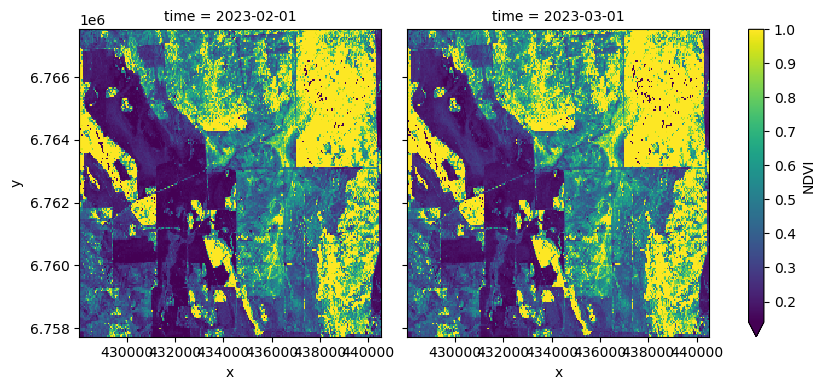

In [16]:
monthly['NDVI'].plot.imshow(col="time", robust=True, size=4)